# Machine Learning using SAS Viya Workbench Python API

## Use Case with Auto Loan Prediction of Probability of Default
<img align="left" src="./data/Auto-Loan-4_sm.jpg">
This example uses SAS's enhanced python APIs. Everything can be replicated using standard python libraries as well. 
The sasviya python API comes pre-loaded in Workbench.

We start by loading some data as a pandas dataframe.
This is a ficticious dataset from a financial services group trying to decide whether to reject loan requests for a vehicle loan request.
The target variable indicates whether historical customers defaulted on their loan or not.

Note that this example is kept relatively simple and by no means includes all steps you would normally take to ensure a quality machine learning model.

Reference: https://github.com/sascommunities/sas-viya-workbench-quick-start-tutorials

Data import: Workbench is great because the same data can be accessed from both python and SAS
1) import from csv
2) read SAS data directly
3) read from SAS library

In [1]:
import os
import pandas as pd
import numpy as np
import saspy

#get Workbench workspace variable (Auto-defined on startup)
WORKSPACE = os.environ['WORKSPACE']
method = 1

if method == 1:
    #read csv using pandas
    df = pd.read_csv(WORKSPACE+"/github/sas-CA-examples/Data/autoloan.csv")
elif method == 2:
    #read sas7bdat using pandas
    df = pd.read_sas(WORKSPACE+'/sasfiles/autoloan.sas7bdat')
elif method == 3:
    #read from sas lib using saspy library
    sas = saspy.SASsession()
    sas.saslib('sasfiles',path=WORKSPACE+'/sasfiles')
    df = sas.sd2df(table='autoloan', libref='sasfiles')
    sas.endsas()


Explore the data a bit

In [2]:
df.head()

,BAD,LOAN,LOANDUE,VALUE,REASON,JOB,YOJ,DEROG,DELINQ,CLAGE,NINQ,CLNO,DEBTINC,APPDATE,CITY,STATE,DIVISION,REGION
0,1.0,1100.0,2586.0,3902.5,CarImp,Other,10.5,0.0,0.0,94.366667,1.0,9.0,NaN,2020-05-05,oregon,Wisconsin,East North Central,Midwest
1,1.0,1300.0,7005.3,6840.0,CarImp,Other,7.0,0.0,2.0,121.833333,0.0,14.0,NaN,2020-11-10,churchton,Maryland,South Atlantic,South
2,1.0,1500.0,1350.0,1670.0,CarImp,Other,4.0,0.0,0.0,149.466667,1.0,10.0,NaN,2018-07-31,orcas,Washington,Pacific,West
3,1.0,1500.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2020-10-25,hastings,Florida,South Atlantic,South
4,0.0,1700.0,9780.0,11200.0,CarImp,Office,3.0,0.0,0.0,93.333333,0.0,14.0,NaN,2021-02-18,wilmington,California,Pacific,West


Let's look at the the target variable. How many are BAD?

In [3]:
freq  = df['BAD'].value_counts().to_frame().reset_index()
freq['Percent'] = df['BAD'].value_counts(normalize=True)*100
print(freq)


   BAD  count    Percent
0  0.0   4771  80.050336
1  1.0   1189  19.949664


We see our target is a binary variable, as expected (BAD stands for Binary Applicant Default)

Approximately 20% of our data points indicate a default (BAD = 1).

<Axes: ylabel='Frequency'>

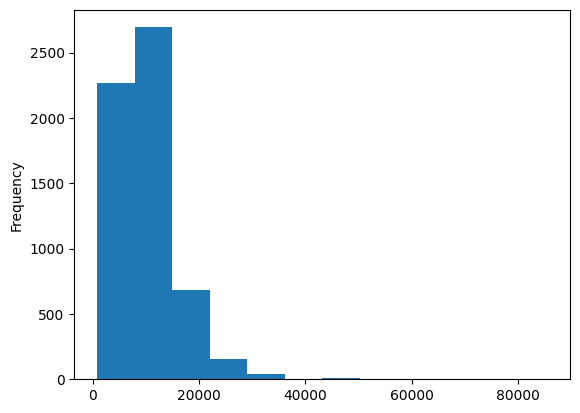

In [4]:
#plot a histogram of the original loan values
df['VALUE'].plot.hist(bins=12)

## Data Preprocessing

We must perform some data preprocessing to prepare this data for machine learning:

- A partition must be created to separate training and validation data
- Missing values must be imputed
- Useful input variables must be selected (the target is BAD)

### Partition

In [5]:
#We use sklearn to partition the data into training and validation data
from sklearn.model_selection import train_test_split

X = df.drop('BAD', axis=1)
y = df['BAD']
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.3, stratify=y, random_state=919)

print("Training data shape:", X_train.shape, "\n" + "Validation data shape:", X_valid.shape)

Training data shape: (4172, 17) 
Validation data shape: (1788, 17)


### Impute missing values

In [6]:
#We use sklearn to impute missing values (using the median/mode from the training data to impute the validation data)
from sklearn.impute import SimpleImputer
import numpy as np

#Calculate the median and mode on the training data to prepare the imputer
imp_interval = SimpleImputer(missing_values=np.nan, strategy='median')
imp_interval.set_output(transform='pandas')
imp_interval = imp_interval.fit(X_train.select_dtypes(include='number'))

imp_nominal = SimpleImputer(missing_values=np.nan, strategy='most_frequent')
imp_nominal.set_output(transform='pandas')
imp_nominal = imp_nominal.fit(X_train.select_dtypes(include='object'))

#Apply the imputation to the training data
X_train_imp_int = imp_interval.transform(X_train.select_dtypes(include='number'))
X_train_imp_nom = imp_nominal.transform(X_train.select_dtypes(include='object'))

X_train_imp = pd.concat([X_train_imp_int, X_train_imp_nom], axis=1)

#Apply the imputation to the validation data
X_valid_imp_int = imp_interval.transform(X_valid.select_dtypes(include='number'))
X_valid_imp_nom = imp_nominal.transform(X_valid.select_dtypes(include='object'))

X_valid_imp = pd.concat([X_valid_imp_int, X_valid_imp_nom], axis=1)

print("Training data shape:", X_train_imp.shape, "\n" + "Validation data shape:", X_valid_imp.shape)

Training data shape: (4172, 17) 
Validation data shape: (1788, 17)


### Downselect input variables

In [7]:
#Select useful input variables using chi-square test
from sklearn.feature_selection import SelectKBest, chi2

#Sklearn requires nominal variables to be dummy coded, for now let's skips this and just select from the interval variables

#Select variables based on the training data
selector = SelectKBest(chi2, k=8).fit(X_train_imp_int, y_train)
selector.set_output(transform="pandas")

#Apply the selection to the training and validation data
train_selected = selector.transform(X_train_imp_int)
valid_selected = selector.transform(X_valid_imp_int)

X_train_final = pd.concat([train_selected, X_train_imp_nom], axis=1)
X_valid_final = pd.concat([valid_selected, X_valid_imp_nom], axis=1)

print("Training data shape:", X_train_final.shape, "\n" + "Validation data shape:", X_valid_final.shape)

print("Selected interval features:", selector.get_feature_names_out())
print("Selected nominal features:", list(X_train_imp_nom.columns))

Training data shape: (4172, 15) 
Validation data shape: (1788, 15)
Selected interval features: ['LOAN' 'LOANDUE' 'VALUE' 'DEROG' 'DELINQ' 'CLAGE' 'NINQ' 'DEBTINC']
Selected nominal features: ['REASON', 'JOB', 'APPDATE', 'CITY', 'STATE', 'DIVISION', 'REGION']


## Machine Learning 

Now that we have a list of relevant input variables (and have identified which are nominal and which are interval) we are ready to start building machine learning models using SAS' sasviya python APIs. This could be reproduced using python's sklearn package as well. We will do this in 3 basic steps:
1. Fit
2. Score
3. Assess

We will build 5 different models:
- Simple Logistic Regression
- Decision Tree
- Random Forest
- Tree-based Gradient Boosting
- Support Vector Machine

### Step 1 - Fit models

In [ ]:
#fit a simple logistic regression model
#NOTE - this is using standard sklearn library and will fail because skelarn can't handle strings                              
from sklearn.linear_model import LogisticRegression

logreg = LogisticRegression(solver='lbfgs',
                        tol=1e-4,
                        max_iter=1000)

logreg.fit(X_train_final, y_train)

In [ ]:
#fit a simple logistic regression model
#NOTE - sasviya.ml automatically handles string variables without error
from sasviya.ml.linear_model import LogisticRegression

logreg = LogisticRegression(solver='lbfgs',
                        tol=1e-4,
                        max_iter=1000)

logreg.fit(X_train_final, y_train)

LogisticRegression(tol=0.0001, solver="lbfgs", max_iter=1000)

In [10]:
#fit a decision tree model
from sasviya.ml.tree import DecisionTreeClassifier

dtree = DecisionTreeClassifier(criterion="chisquare",
                               max_depth=10,
                               ccp_alpha=0)

dtree.fit(X_train_final, y_train)

DecisionTreeClassifier(criterion="chisquare")

In [11]:
#fit a random forest model
from sasviya.ml.tree import ForestClassifier

forest = ForestClassifier(criterion="chisquare",
                          n_estimators=100,
                          bootstrap=0.6,
                          max_depth=7,
                          min_samples_leaf=5,
                          random_state=919)

forest.fit(X_train_final, y_train)

ForestClassifier(criterion="chisquare", max_depth=7, random_state=919)

In [12]:
#fit a tree-based gradient boosting model
from sasviya.ml.tree import GradientBoostingClassifier

gradboost = GradientBoostingClassifier(n_estimators=100,
                                       max_depth=4,
                                       min_samples_leaf=5,
                                       learning_rate=0.1,
                                       subsample=0.8,
                                       random_state=919)

gradboost.fit(X_train_final, y_train)

GradientBoostingClassifier(subsample=0.8, random_state=919)

In [13]:
#fit a support vector machine classifier
from sasviya.ml.svm import SVC

svm = SVC(C=1.0,
          kernel="rbf")

svm.fit(X_train_final, y_train)

SVC(kernel="rbf")

### Step 2 - Score fitted models against training and validation data sets

In [17]:
#score training and validation data using the fitted models (we can assess them separately after this)
models = ['logreg', 'dtree','forest','gradboost','svm']
train_out = dict.fromkeys(models, None)
valid_out = dict.fromkeys(models, None)

#score the training and validation data using the models, and join the predictions to the target
for model in models:
    train_out[model] = eval(model).predict_proba(X_train_final)
    train_out[model] = train_out[model].join(y_train)

    valid_out[model] = eval(model).predict_proba(X_valid_final)
    valid_out[model] = valid_out[model].join(y_valid)

### Step 3 - Assess model performance against validation data

Text(0, 0.5, 'True Positive Rate')

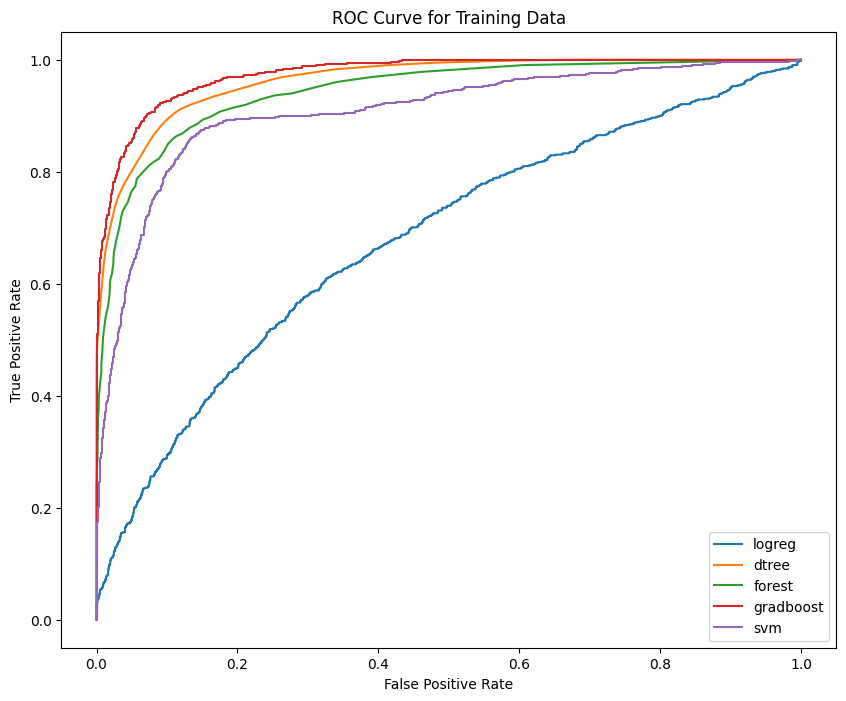

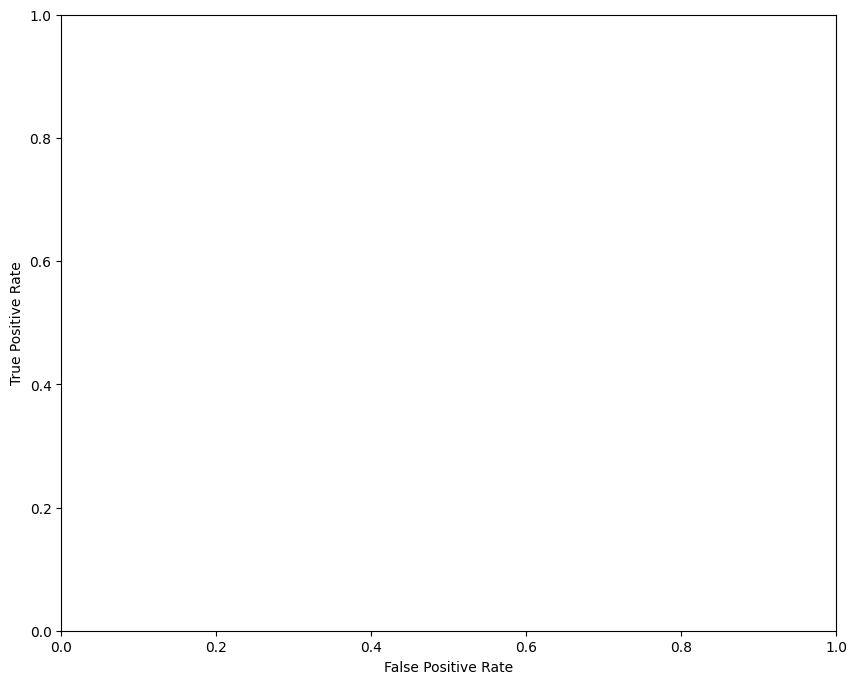

In [18]:
#plot ROC
from sklearn.metrics import roc_curve
from matplotlib import pyplot as plt

train_roc = dict.fromkeys(models, None)
valid_roc = dict.fromkeys(models, None)

plt.figure(figsize=(10,8))
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

plt.title('ROC Curve for Training Data')
for model in models:
    train_roc[model] = roc_curve(train_out[model]['BAD'], train_out[model]['P_BAD1'], pos_label=1)
    plt.plot(train_roc[model][0], train_roc[model][1])
plt.legend(models)

plt.figure(figsize=(10,8))
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

#plt.title('ROC Curve for Validation Data')
#for model in models:
#    valid_roc[model] = roc_curve(valid_out[model]['BAD'], valid_out[model]['P_BAD1'], pos_label=1)
#    plt.plot(valid_roc[model][0], valid_roc[model][1])
#plt.legend(models);

The gradient boosting and random forest models appear to have both performed the best on the validation data. Let's print out the misclassificaiton rate of both. 

In [19]:
#Calculate misclassification for 'champion' model on validation data
from sklearn.metrics import accuracy_score

cutoff = 0.5
valid_preds = [1 if valid_out['gradboost']['P_BAD1'][elem] > cutoff else 0 for elem in valid_out['gradboost'].index]

print('Misclassification Rate on Validation Data for Gradient Boosting at',cutoff,'cutoff:', 1-accuracy_score(valid_out['gradboost']['BAD'], valid_preds))

valid_preds = [1 if valid_out['forest']['P_BAD1'][elem] > cutoff else 0 for elem in valid_out['forest'].index]

print('Misclassification Rate on Validation Data for Random Forest at',cutoff,'cutoff:', 1-accuracy_score(valid_out['gradboost']['BAD'], valid_preds))

Misclassification Rate on Validation Data for Gradient Boosting at 0.5 cutoff: 0.09731543624161076
Misclassification Rate on Validation Data for Random Forest at 0.5 cutoff: 0.12583892617449666


The gradient boosting model performs better in terms of misclassification rate. 


# Model Registration

In [2]:
from sasctl import pzmm
from sasctl import Session
from sasctl.services import model_repository as mr, model_management as mm
from pathlib import Path
import requests
import os

In [3]:
## get access token for viya env using refresh token. change to your own viya server and preferred authentication method.
url = "https://innovationlab.demo.sas.com"

access_token = ''

In [4]:
st = Session(url, token=access_token, verify_ssl=False)
st


In [5]:
repository = mr.get_repository('DMRepository')
repository.name



/usr/local/lib/python3.11/site-packages/urllib3/connectionpool.py:1103: InsecureRequestWarning: Unverified HTTPS request is being made to host 'innovationlab.demo.sas.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


'DMRepository'

In [6]:
project_name = 'workbench_project'
model_name = 'gradboost_py'

project = mr.get_project(project_name)

/workspaces/myfolder/.user-python-packages/lib/python3.11/site-packages/sasctl/_services/service.py:270: UserWarning: Multiple items found with name 'workbench_project'.  Only the first result is returned.
  warnings.warn(


In [7]:
def register_model(model_name, model, project):
    model_params = {
        "name": model_name,
        "projectId": project.id,
        "type": "ASTORE",
    }
    astore = mr.post(
        "/models",
        files={"files": (f"{model_name}.astore", model.export())},
        data=model_params,
    )